# **Crime Risk in DC - Analysis**

### Packages

In [26]:
import requests
import json
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 100)

### Read in API data (2015-2019)

Below is the crime incident data for 2015-2019 from OpenDataDC (https://opendata.dc.gov/). There is a seperate API for each year, so the code below reads in the data, converts it into dataframes and concatenates them.

In [70]:
url_crime_2015 = 'https://opendata.arcgis.com/datasets/35034fcb3b36499c84c94c069ab1a966_27.geojson'
df_crime_2015 = gpd.read_file(url_crime_2015)

In [71]:
url_crime_2016 = 'https://opendata.arcgis.com/datasets/bda20763840448b58f8383bae800a843_26.geojson'
df_crime_2016 = gpd.read_file(url_crime_2016)

In [72]:
url_crime_2017 = 'https://opendata.arcgis.com/datasets/6af5cb8dc38e4bcbac8168b27ee104aa_38.geojson'
df_crime_2017 = gpd.read_file(url_crime_2017)

In [73]:
url_crime_2018 = 'https://opendata.arcgis.com/datasets/38ba41dd74354563bce28a359b59324e_0.geojson'
df_crime_2018 = gpd.read_file(url_crime_2018)

In [74]:
url_crime_2019 = 'https://opendata.arcgis.com/datasets/f08294e5286141c293e9202fcd3e8b57_1.geojson'
df_crime_2019 = gpd.read_file(url_crime_2019)

In [75]:
df_crime = pd.concat([df_crime_2015, df_crime_2016, df_crime_2017, df_crime_2018, df_crime_2019])

### Clean API Data

Remove unnecessary columns form the dataframe.

In [76]:
df_crime = df_crime[['CCN', 'START_DATE', 'END_DATE', 'REPORT_DAT', 'SHIFT', 'WARD', 'BLOCK_GROUP', 'CENSUS_TRACT', 
                     'BLOCK', 'OFFENSE', 'METHOD', 'LATITUDE', 'LONGITUDE']]

In [77]:
df_crime['year'] = pd.DatetimeIndex(df_crime['START_DATE']).year
df_crime['month'] = pd.DatetimeIndex(df_crime['START_DATE']).month
df_crime['dayofweek'] = pd.DatetimeIndex(df_crime['START_DATE']).dayofweek

df_crime['dayofweek'] = df_crime['dayofweek'].map({0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 
                                                   5:'Saturday', 6:'Sunday'})
df_crime = df_crime[pd.notnull(df_crime['START_DATE'])]

In [78]:
df_crime['date'] = df_crime['START_DATE']
df_crime.date = pd.to_datetime(df_crime.date, format='%Y/%m/%d %H:%M:%S')

df_crime.index = pd.to_datetime(df_crime.START_DATE, format='%Y/%m/%d %H:%M:%S')
df_crime.END_DATE = pd.to_datetime(df_crime.END_DATE, format='%Y/%m/%d %H:%M:%S')
df_crime.REPORT_DAT = pd.to_datetime(df_crime.REPORT_DAT, format='%Y/%m/%d %H:%M:%S')

In [79]:
# get names of indexes for columns with report dates before 2015
indexNames = df_crime[df_crime['year'] < 2015].index
# delete these row indexes from df_crime
df_crime.drop(indexNames, inplace=True)

In [80]:
hours = df_crime['date'].dt.hour
bins = [-1, 4, 9, 17, 21]
labels = ['Night', 'Morning', 'Afternoon', 'Evening', 'Night']
df_crime['time_of_day'] = np.array(labels)[np.array(bins).searchsorted(hours)-1]

In [82]:
df_crime.head()

,CCN,START_DATE,END_DATE,REPORT_DAT,SHIFT,WARD,BLOCK_GROUP,CENSUS_TRACT,BLOCK,OFFENSE,METHOD,LATITUDE,LONGITUDE,year,month,dayofweek,date,time_of_day
START_DATE,,,,,,,,,,,,,,,,,,
2015-05-14 13:24:00,15069981,2015-05-14T13:24:00,2015-05-14 13:24:00,2015-05-14 00:00:00,MIDNIGHT,3,000400 2,000400,3200 - 3299 BLOCK OF WOODLAND DRIVE NW,HOMICIDE,KNIFE,38.926887,-77.064513,2015.0,5.0,Thursday,2015-05-14 13:24:00,Afternoon
2015-05-14 13:24:00,15069981,2015-05-14T13:24:00,2015-05-14 13:24:00,2015-05-14 00:00:00,MIDNIGHT,3,000400 2,000400,3200 - 3299 BLOCK OF WOODLAND DRIVE NW,HOMICIDE,KNIFE,38.926887,-77.064513,2015.0,5.0,Thursday,2015-05-14 13:24:00,Afternoon
2015-05-14 13:24:00,15069981,2015-05-14T13:24:00,2015-05-14 13:24:00,2015-05-14 00:00:00,MIDNIGHT,3,000400 2,000400,3200 - 3299 BLOCK OF WOODLAND DRIVE NW,HOMICIDE,KNIFE,38.926887,-77.064513,2015.0,5.0,Thursday,2015-05-14 13:24:00,Afternoon
2015-06-25 01:00:00,15095401,2015-06-25T01:00:00,2015-06-25 03:00:00,2015-06-25 04:51:00,MIDNIGHT,5,003302 1,003302,1 - 99 BLOCK OF RHODE ISLAND AVENUE NW,SEX ABUSE,GUN,38.916257,-77.010597,2015.0,6.0,Thursday,2015-06-25 01:00:00,Night
2015-06-25 01:00:00,15095401,2015-06-25T01:00:00,2015-06-25 03:00:00,2015-06-25 04:51:00,MIDNIGHT,5,003302 1,003302,1 - 99 BLOCK OF RHODE ISLAND AVENUE NW,SEX ABUSE,GUN,38.916257,-77.010597,2015.0,6.0,Thursday,2015-06-25 01:00:00,Night


### Visualizations

The below visualizations are for the purposes of exploratory data analysis.

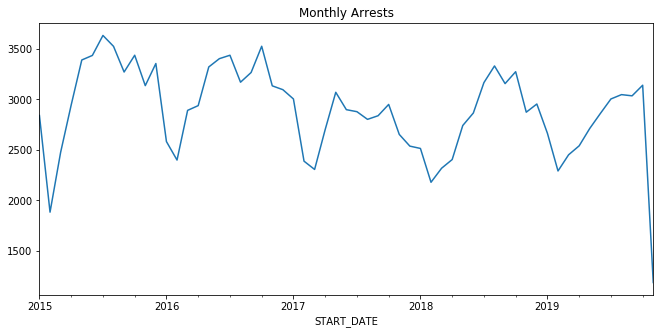

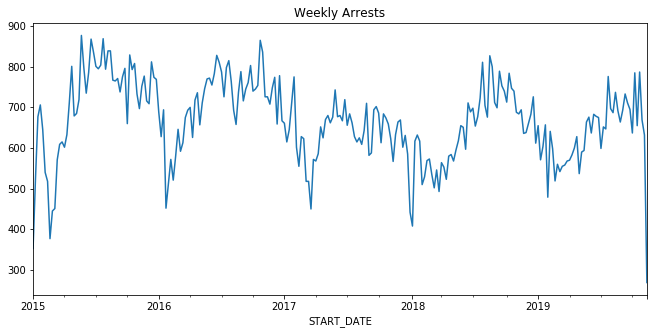

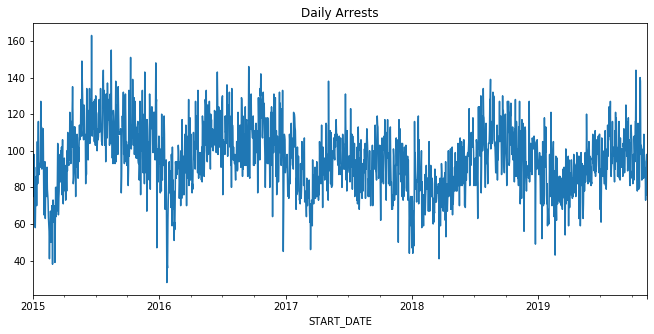

In [47]:
# number of crimes per month
plt.figure(figsize=(11, 5))
df_crime.resample('m').size().plot()
plt.title('Monthly Arrests')
plt.show()

# number of crimes per week
plt.figure(figsize=(11, 5))
df_crime.resample('W').size().plot()
plt.title('Weekly Arrests')
plt.show()

# number of crimes per day
plt.figure(figsize=(11, 5))
df_crime.resample('d').size().plot()
plt.title('Daily Arrests')
plt.show()
plt.show()

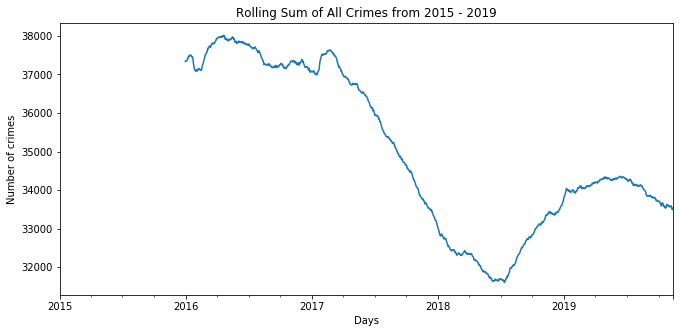

In [44]:
# rolling sum of all crimes

plt.figure(figsize=(11, 5))
df_crime.resample('d').size().rolling(365).sum().plot()
plt.title('Rolling Sum of All Crimes from 2015 - 2019')
plt.ylabel('Number of crimes')
plt.xlabel('Days')
plt.show()

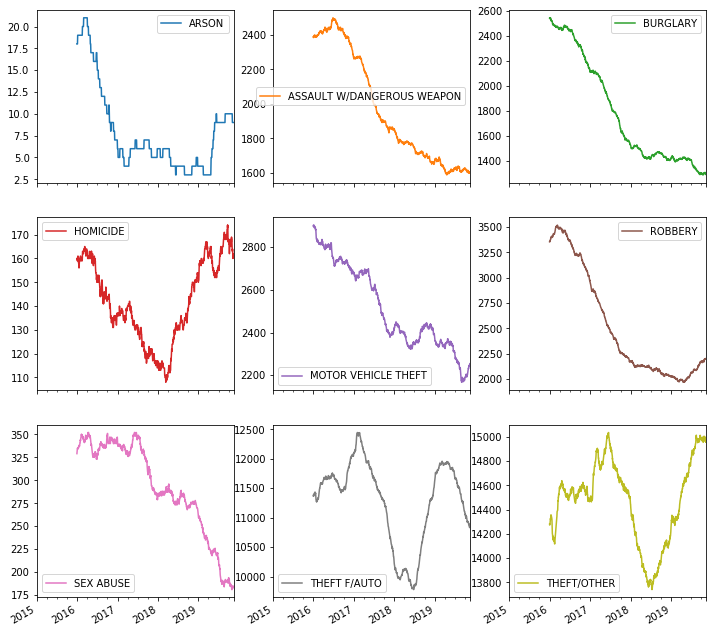

In [43]:
# rolling sum of crimes by offense type

crimes_count_date = df_crime.pivot_table('CCN', aggfunc=np.size, columns='OFFENSE', index=df_crime.index.date, fill_value=0)
crimes_count_date.index = pd.DatetimeIndex(crimes_count_date.index)
plo = crimes_count_date.rolling(365).sum().plot(figsize=(12, 12), subplots=True, layout=(-1, 3))
plt.show()

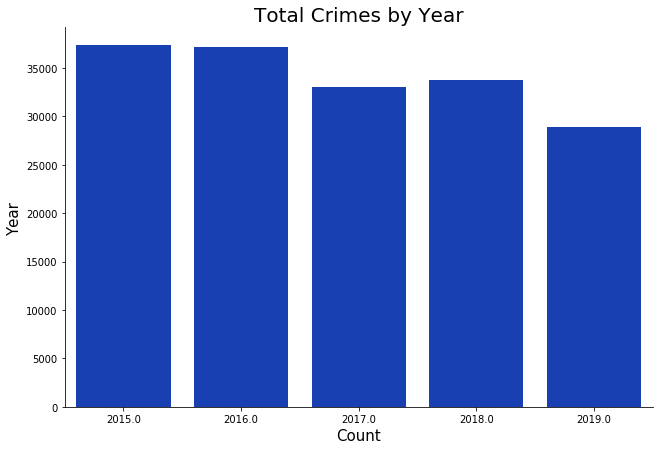

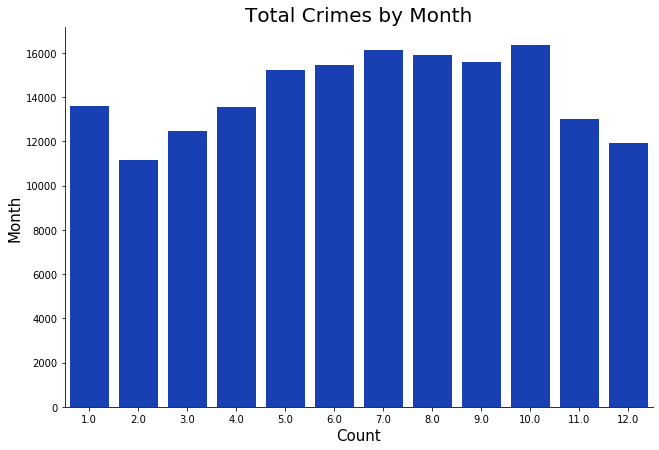

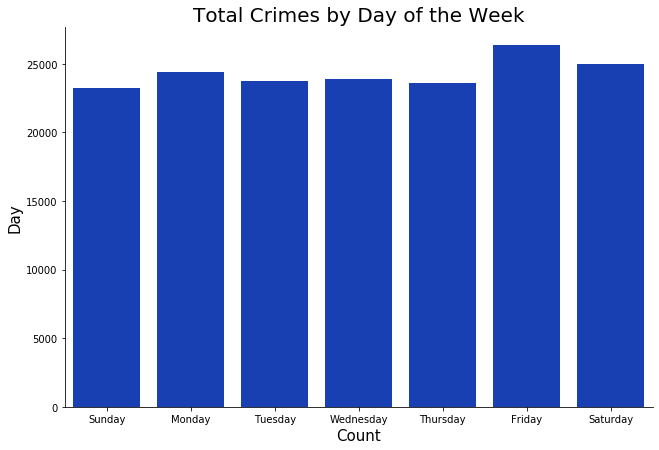

In [14]:
color = ['#0033cc']

# categorical plot for total crimes by year
sns.catplot(x='year', kind='count', height=6, aspect=1.5,
            data=df_crime, palette=sns.color_palette(color))
plt.title('Total Crimes by Year', fontsize=20)
plt.xticks(size=10)
plt.yticks(size=10)
plt.xlabel('Count', fontsize=15)
plt.ylabel('Year', fontsize=15)
plt.show()

# categorical plot for total crimes by month
sns.catplot(x='month', kind='count', height=6, aspect=1.5,
            data=df_crime, palette=sns.color_palette(color))
plt.title('Total Crimes by Month', fontsize=20)
plt.xticks(size=10)
plt.yticks(size=10)
plt.xlabel('Count', fontsize=15)
plt.ylabel('Month', fontsize=15)
plt.show()

# categorical plot for total crimes by day of the week
sns.catplot(x='dayofweek', kind='count', height=6, aspect=1.5,
            data=df_crime, palette=sns.color_palette(color), 
            order=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
plt.title('Total Crimes by Day of the Week', fontsize=20)
plt.xticks(size=10)
plt.yticks(size=10)
plt.xlabel('Count', fontsize=15)
plt.ylabel('Day', fontsize=15)
plt.show()

Text(-150.559375, 0.5, 'Offense Type')

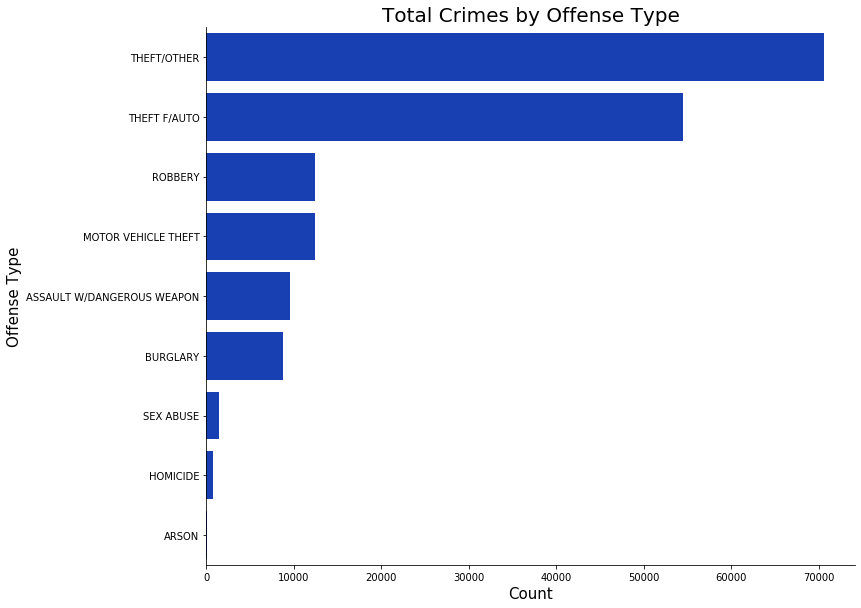

In [15]:
# categorical plot for count of offense type

sns.catplot(y='OFFENSE', kind='count', height=8, aspect=1.5, order=df_crime.OFFENSE.value_counts().index, 
            data=df_crime, palette=sns.color_palette(color))

plt.title('Total Crimes by Offense Type', fontsize=20)
plt.xticks(size=10)
plt.yticks(size=10)
plt.xlabel('Count', fontsize=15)
plt.ylabel('Offense Type', fontsize=15)

In [ ]:
# type of weapon used in attack

method_df = pd.DataFrame(df_crime.METHOD.value_counts())
method_df = method_df.rename(columns={'METHOD': 'Weapon Used'})
# method_df = method_df.reset_index()
# s = pd.Series([1, 2, 3])
# method_df.set_index(s)

# method_pie = method_df.plot.pie(y='Weapon Used', figsize=(7, 7))
# # Create a pie chart
# plt.pie(
#     # using data total)arrests
#     method_df['Weapon Used'],
#     # with the labels being officer names
#     labels=method_df['index'],
#     # with no shadows
#     shadow=False,
#     # with one slide exploded out
#     explode=(0.15, 0, 0),
#     # with the start angle at 90%
#     startangle=90,
#     )

# # View the plot drop above
# plt.axis('equal')

# # View the plot
# plt.tight_layout()
# plt.show()

method_df.plot(kind='pie', subplots=True, figsize=(16,8))


In [ ]:
method_df

In [ ]:
# categorical plot for count of total crimes by neighborhood and time of day

sns.catplot(x='BLOCK', hue='SHIFT', kind='count', height=8, aspect=1.5, order=df_crime.BLOCK.value_counts().index, 
            data=df_crime, legend=False)

plt.title('Total Crimes by Neighborhood and Time of Day', fontsize=20)

plt.xticks(size=10, rotation=90)
plt.yticks(size=10)
plt.xlabel('Neighborhood', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.legend(title='Time of Day', loc='right')

In [ ]:
# categorical plot for count of total crimes by ward and time of day

sns.catplot(x='WARD', hue='SHIFT', kind='count', height=8, aspect=1.5, order=df_crime.WARD.value_counts().index, 
            data=df_crime, legend=False)

plt.title('Total Crimes by Ward and Time of Day', fontsize=20)

plt.xticks(size=10)
plt.yticks(size=10)
plt.xlabel('Ward', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.legend(title='Time of Day', loc='right')

#### Tableau map of crimes by ward

In [ ]:
# %%HTML 

# <div class='tableauPlaceholder' id='viz1570313986891' style='position: relative'>
#     <noscript>
#         <a href='#'>
#             <img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;dc&#47;dc_crimes_map&#47;DCCrimesbyWard2017-2019&#47;1_rss.png' style='border: none' />
#         </a>
#     </noscript>
#     <object class='tableauViz'  style='display:none;'>
#         <param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> 
#         <param name='embed_code_version' value='3' /> 
#         <param name='site_root' value='' />
#         <param name='name' value='dc_crimes_map&#47;DCCrimesbyWard2017-2019' />
#         <param name='tabs' value='no' />
#         <param name='toolbar' value='yes' />
#         <param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;dc&#47;dc_crimes_map&#47;DCCrimesbyWard2017-2019&#47;1.png' /> 
#         <param name='animate_transition' value='yes' />
#         <param name='display_static_image' value='yes' />
#         <param name='display_spinner' value='yes' />
#         <param name='display_overlay' value='yes' />
#         <param name='display_count' value='yes' />
#         <param name='filter' value='publish=yes' />
#     </object>              
#     <script type='text/javascript'>                    
#         var divElement = document.getElementById('viz1570313986891');                    
#         var vizElement = divElement.getElementsByTagName('object')[0];                    
#         vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    
#         var scriptElement = document.createElement('script');                    
#         scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    
#         vizElement.parentNode.insertBefore(scriptElement, vizElement);                
#     </script>
# </div>